In [20]:
import os, arbor, plotly.express as px, pandas as pd
print('arbor version:', arbor.config()['version'])
if not os.path.exists('iopublic'):
    !git clone --depth 1 'https://github.com/llandsmeer/iopublic'

arbor version: 0.8.1


# Morphology

In [2]:
import arbor
import numpy as np
import plotly.express as px

In [3]:
morph = arbor.neuroml('./C51A.cell.nml').cell_morphology('C51A')

In [30]:
segs = sum((morph.morphology.branch_segments(i) for i in range(morph.morphology.num_branches)), [])
segs = np.array(
    [(i, s.prox.x, s.prox.y, s.prox.z, s.prox.radius) for i, s in enumerate(segs)] +
    [(i, s.dist.x, s.dist.y, s.dist.z, s.prox.radius) for i, s in enumerate(segs)])

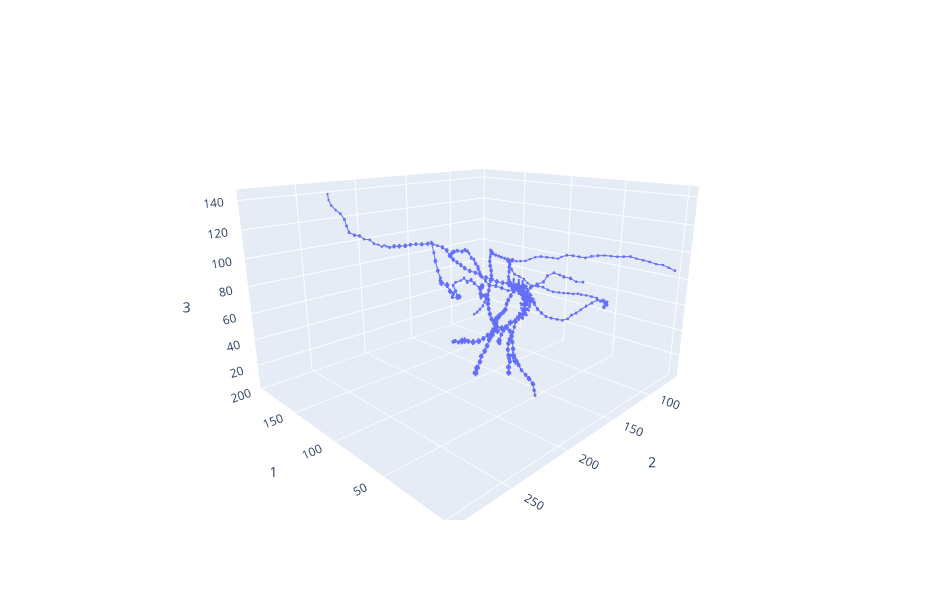

In [37]:
fig = px.line_3d(segs, x=1, y=2, z=3, error_x=4, error_y=4, error_z=4, line_group=0)
fig.update_layout(
    autosize=True,
    height=600,
    scene=dict(camera=dict(eye=dict(x=-1.4, y=1.4, z=0.6))),
    )

# Biophysics

In [8]:
if not os.path.exists('io-catalogue.so'):
    !arbor-build-catalogue io iopublic/smol_model --cxx g++

In [10]:
def make_decor(R=lambda x: x):
    return (arbor.decor()
        .paint('"soma_group"', arbor.density('na_s', dict(gmax=R(0.030))))
        .paint('"soma_group"', arbor.density('kdr',  dict(gmax=R(0.030))))
        .paint('"soma_group"', arbor.density('cal',  dict(gmax=R(0.045))))
        .paint('"dendrite_group"', arbor.density('cah',  dict(gmax=R(0.010))))
        .paint('"dendrite_group"', arbor.density('kca',  dict(gmax=R(0.220))))
        .paint('"dendrite_group"', arbor.density('h',    dict(gmax=R(0.015))))
        .paint('"dendrite_group"', arbor.density('cacc', dict(gmax=R(0.000))))
        .paint('"axon_group"', arbor.density('na_a', dict(gmax=R(0.200))))
        .paint('"axon_group"', arbor.density('k',    dict(gmax=R(0.200))))
        .paint('"soma_group"', arbor.density('k',    dict(gmax=R(0.015))))
        .paint('(all)',  arbor.density('leak', dict(gmax=R(1.3e-05))))
        .set_property(cm=0.01)
        .set_property(Vm=-R(65.0))
        .paint('(all)', rL=100)
        .paint('(all)', ion_name='ca', rev_pot=R(120), int_con=3.7152)
        .paint('(all)', ion_name='na', rev_pot=R(55))
        .paint('(all)', ion_name='k', rev_pot=-R(75))
        .paint('(all)', arbor.density('ca_conc'))
    )

io_catalogue = arbor.load_catalogue('./io-catalogue.so')
nml = arbor.neuroml('C51A.cell.nml').cell_morphology('C51A')
label = arbor.label_dict()
label.append(nml.segments())
label.append(nml.named_segments())
label.append(nml.groups())
c51a_default = arbor.cable_cell(nml.morphology, make_decor(), label)

# Single cell simulation

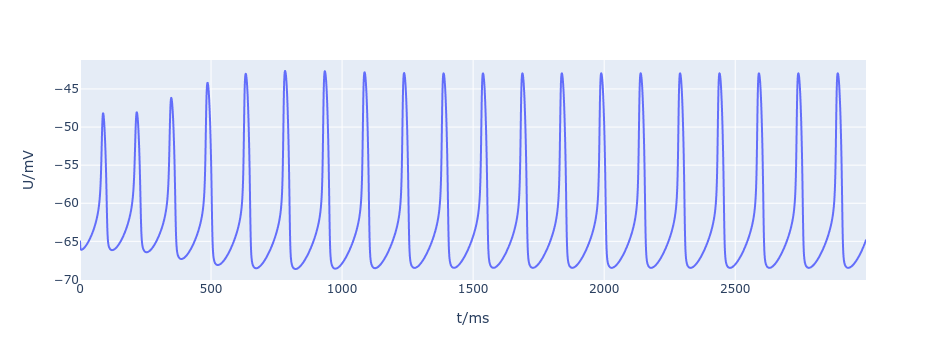

In [26]:
m = arbor.single_cell_model(c51a_default)
m.properties.catalogue.extend(io_catalogue, '')
m.probe("voltage", '(root)', frequency=1)
m.run(tfinal=3000, dt=0.025)
df = pd.DataFrame({"t/ms": m.traces[0].time, "U/mV": m.traces[0].value})
px.line(df, x='t/ms', y='U/mV')